In [ ]:
######################################### Load Libraries and Modules #########################################
#LATEST MODELING CODE AT THE END OF THE SCRIPT! @09/22 BY SUMMER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from sklearn.model_selection import train_test_split # splits arrays or matrices into random train and test subsets
from sklearn.metrics import accuracy_score, f1_score, classification_report # the sklearn.metrics module includes performance metrics
from sklearn.linear_model import LogisticRegression        # the sklearn.linear_model module implements generalized linear models. LogReg is part of this module
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Encode the labels
le.fit(['B','M'])
# Show the label classes
print(le.classes_)
# Transform the label of the table
df[1] = le.transform(df[1])


['B' 'M']


#A). Using the nested cross-validation technique to optimize the parameter

In [ ]:
y = df[1]                               # Column one 0: Benign, and 1: Malignant
X = df.loc[:, 2:  ]               # Select all columns except column 0 and 1

In [ ]:
############################### Import Libraries & Modules #################################
from sklearn.tree import DecisionTreeClassifier # A decision tree classifier
# GridSearchCV performs an exhaustive search over specified parameter values for an estimator
# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
# Pipeline of transforms with a final estimator
from sklearn.pipeline import Pipeline
import numpy as np


np.random.seed(42) # ensure reproducability

# Prepare the data by defining the label and explanatory variable. 

################################# Nested Cross-Validation #################################

##################################### Parameter Tuning ####################################

# Exhaustive search over specified parameter values for an estimator.
# GridSearchCV implements a “fit” and a “score” method. 
# It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” 
# if they are implemented in the estimator used.

# The parameters of the estimator used to apply these methods are optimized by cross-validated 
# grid-search over a parameter grid.
# KFold splits dataset into k consecutive folds (without shuffling by default)

inner_cv = KFold(n_splits=5, shuffle=True) # inner cross-validation folds
outer_cv = KFold(n_splits=5, shuffle=True) # outer cross-validation folds
    
############################## Decision Tree Parameter Tuning ##############################

# Choosing depth of the tree AND splitting criterion AND min_samples_leaf AND min_samples_split
gs_dt2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None], 
                               'criterion':['gini','entropy'], 
                               'min_samples_leaf':[1,2,3,4,5],
                               'min_samples_split':[2,3,4,5]}],
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_dt2 = gs_dt2.fit(X,y)
print("\n Parameter Tuning(max_depth, criterion, min_smaples_leaf, min_samples_split) for Decision Tree")
print("Non-nested CV F1-Score: ", gs_dt2.best_score_)
print("Optimal Parameter: ", gs_dt2.best_params_)
print("Optimal Estimator: ", gs_dt2.best_estimator_)
nested_score_gs_dt2 = cross_val_score(gs_dt2, X=X, y=y, cv=outer_cv)
print("Nested CV F1-Score: ",nested_score_gs_dt2.mean(), " +/- ", nested_score_gs_dt2.std())



 Parameter Tuning(max_depth, criterion, min_smaples_leaf, min_samples_split) for Decision Tree
Non-nested CV F1-Score:  0.9346928746928747
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Optimal Estimator:  DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)
Nested CV F1-Score:  0.9147744492316287  +/-  0.024981294787751095


In [ ]:
############################ Logistic Regression Parameter Tuning ############################
#To ignore the convergence warnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

np.random.seed(42) # ensure reproducability

# Choosing C parameter for Logistic Regression AND type of penalty (ie., l1 vs l2)
# See other parameters here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
gs_lr2 = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=[{'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000],
                              'penalty':['l1','l2']}],
                  scoring='f1',
                  cv=inner_cv)

gs_lr2 = gs_lr2.fit(X,y)
print("\n Parameter Tuning(C, penalty) for Logistic Regression")
print("Non-nested CV F1-Score: ", gs_lr2.best_score_)
print("Optimal Parameter: ", gs_lr2.best_params_)
print("Optimal Estimator: ", gs_lr2.best_estimator_)
nested_score_gs_lr2 = cross_val_score(gs_lr2, X=X, y=y, cv=outer_cv)
print("Nested CV F1-Score:",nested_score_gs_lr2.mean(), " +/- ", nested_score_gs_lr2.std())
 


 Parameter Tuning(C, penalty) for Logistic Regression
Non-nested CV F1-Score:  0.9576785075389728
Optimal Parameter:  {'C': 100, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')


In [ ]:
################################### kNN Parameter Tuning ###################################
np.random.seed(42) # ensure reproducability

#Normalize Data
pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier(p=2, 
                                     metric='minkowski')) 
      ])

#Parameters to optimize:  k for number of nearest neighbors AND type of distance

params = {
        'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
        'knn__weights': ['uniform', 'distance']
    }

gs_knn2 = GridSearchCV(estimator=pipe,
                  param_grid=params,
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=4)

gs_knn2 = gs_knn2.fit(X,y)  
print("\n Parameter Tuning(knn__n_neighbors,knn__weights) for kNN")
print("Non-nested CV F1-Score: ", gs_knn2.best_score_)
print("Optimal Parameter: ", gs_knn2.best_params_)
print("Optimal Estimator: ", gs_knn2.best_estimator_) # Estimator that was chosen by the search, i.e. estimator which gave highest score
nested_score_gs_knn2 = cross_val_score(gs_knn2, X=X, y=y, cv=outer_cv)
print("Nested CV F1-Score: ",nested_score_gs_knn2.mean(), " +/- ", nested_score_gs_knn2.std())


 Parameter Tuning(knn__n_neighbors,knn__weights) for kNN
Non-nested CV F1-Score:  0.9523682840047905
Optimal Parameter:  {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Optimal Estimator:  Pipeline(steps=[('sc', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])
Nested CV F1-Score:  0.9492982074989029  +/-  0.017757982733385847


## B. LEARNING CURVES

In [ ]:
############################## Function for Learning Curves ##############################

def plot_learning_curve(estimator,        # data science algorithm
                        title,            # title of the plot
                        X, y,             # data (features and target variable)
                        ylim=None,        # minimum and maximum y values plotted
                        cv=None,          # cross validation splits
                        n_jobs=1,         # parallell estimation using multiple processors
                        train_sizes=np.linspace(.1, 1.0, 10)): #linspace returns evenly spaced numbers over a specified interval (start, stop, num)


    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()                    # display figure
    plt.title(title)                # specify title based on parameter provided as input
    if ylim is not None:            # if ylim was specified as an input, make sure the plots use these limits
        plt.ylim(*ylim)
    plt.xlabel("Training examples") # y label title
    plt.ylabel("Score")             # x label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(estimator, # data science algorithm
                                                            X, y,      # data (features and target variable)  
                                                            cv=cv,     # cross-validation folds
                                                            n_jobs=n_jobs, # number of jobs to run in parallel using multiple processors
                                                            train_sizes=train_sizes) # relative or absolute numbers of training examples 
                                                                                     # that will be used to generate the learning curve
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis.

    plt.grid()                                        # configure the grid lines in the plot

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes,                            # the x coordinates of the nodes defining the curves
                     train_scores_mean - train_scores_std,   # the y coordinates of the nodes defining the first curve
                     train_scores_mean + train_scores_std,   # the y coordinates of the nodes defining the second curve
                     alpha=0.1,                              # level of transparency in the color fill
                     color="r")                              # train data performance indicated with red
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1,
                     color="g")                              # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes,                                    # the horizontal coordinates of the data points 
             train_scores_mean,                              # the vertical coordinates of the data points
             'o-',                                           # o- will produce a small circle and a solid line to connect the markers
             color="r",                                      # line of red color
             label="Training score")                         # specify label title for this plot
    
    # Test data performance indicated with green
    plt.plot(train_sizes, 
             test_scores_mean, 
             'o-', 
             color="g",                                      # line of green color
             label="Cross-validation score")

    plt.legend(loc="best")                      # show legend of the plot at the best location possible
    return plt 

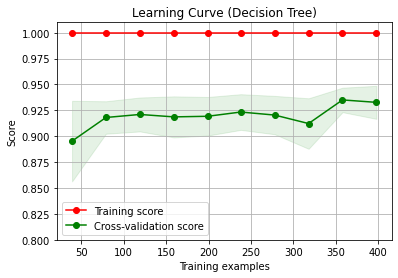

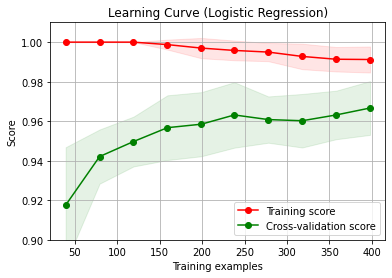

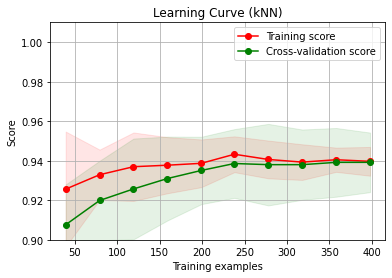

In [ ]:
########################### Visualization of Learning Curves ###########################

# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve 
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt



title = "Learning Curve (Decision Tree)"

# Class ShuffleSplit is a random permutation cross-validator
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.3,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = DecisionTreeClassifier()        # build multiple Decision Tree models as we increase the size of the traning data

# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X, y,           # data (features and target variable)
                    (0.8, 1.01),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show()                          # display the figure


title = "Learning Curve (Logistic Regression)"

# Class ShuffleSplit is a random permutation cross-validator
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.3,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')    # build multiple LR models as we increase the size of the traning data
                                                                                            # Note that we used the optimal LR parameters we got from the GridSearch

# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X, y,           # data (features and target variable)
                    (0.9, 1.01),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show()                          # display the figure

title = "Learning Curve (kNN)"

# Plots the learning curve based on the previously defined function for the kNN classifier. Uses the 
# random permutation cross-validator
cv = ShuffleSplit(n_splits=10, 
                  test_size=0.3, 
                  random_state=42)
estimator = neighbors.KNeighborsClassifier()  # build multiple kNN models as we increase the size of the traning data
                                              # n_neighbors=5 by default
plot_learning_curve(estimator, 
                    title, 
                    X, y, 
                    (0.9, 1.01), 
                    cv=cv, 
                    n_jobs=4)

plt.show()                          #display the figure

## C. FITTING CURVES

In [ ]:
###################################### Classifier ######################################

X_train, X_test, y_train, y_test = train_test_split(X,              
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

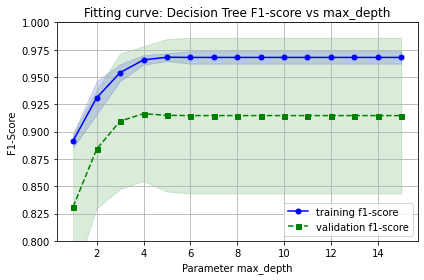

In [ ]:
# Fitting curve (aka validation curve)
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve


np.random.seed(42)                        # the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values for max_depth of the tree.
param_range = range(1,16)

# Compute scores for an estimator with different values of a specified parameter. 
# This is similar to grid search with one parameter. 
# However, this will also compute training scores and is merely a utility for plotting the results.

########################## Estimate Scores - Varying Complexity ##########################

train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(min_samples_leaf=5, criterion='gini', min_samples_split=2, random_state=42), # build Decision Tree models
                X=X_train,                                          # data (features)
                y=y_train,                                          # target variable
                param_name="max_depth",                       # parameter max_depth: enforce the maximum deth of the decision tree model; 
                param_range=param_range,                      # the values of the parameter that will be evaluated
                cv=10,                                        # 10-fold cross-validation
                scoring="f1",                                 # evaluation metric
                n_jobs=-1)


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)   
test_mean = np.mean(test_scores, axis=1) 
test_std = np.std(test_scores, axis=1)    

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range,                  
         train_mean,                      
         color='blue',                    
         marker='o',                      
         markersize=5,                    
         label='training f1-score')       

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range,             # the x coordinates of the nodes defining the curves
                 train_mean + train_std,  # the y coordinates of the nodes defining the first curve
                 train_mean - train_std,  # the y coordinates of the nodes defining the second curve
                 alpha=0.15,              # level of transparency in the color fill
                 color='blue')            # aesthetic parameter - color

# Plot test accuracy means of cross-validation for all the parameters max_depth in param_range
plt.plot(param_range, 
         test_mean, 
         color='green', 
         linestyle='--', 
         marker='s', 
         markersize=5, 
         label='validation f1-score')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.title("Fitting curve: Decision Tree F1-score vs max_depth")
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.ylabel('F1-Score')
plt.ylim([0.8, 1.0]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()                            # display the figure

# D. ROC CURVES

10-fold cross validation:

ROC AUC: 0.99 (+/- 0.01) [Logistic regression]
ROC AUC: 0.95 (+/- 0.03) [Decision tree]
ROC AUC: 0.99 (+/- 0.01) [kNN]


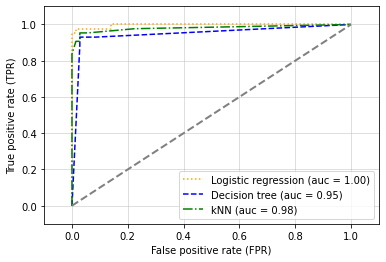

In [ ]:
############################### Import Libraries & Modules #################################

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

######################################## Classifiers ########################################
# Logistic Regression Classifier
clf1 = LogisticRegression(penalty='l1', 
                          C=100,
                          random_state=42, 
                          solver='liblinear') 

# Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=5,
                              criterion='gini',
                              min_samples_leaf=5,
                              min_samples_split=2,
                              random_state=42)

# kNN Classifier

clf3 = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier(n_neighbors=9,
                                     p=2, 
                                     metric='minkowski')) 
      ])

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [clf1, clf2, clf3]

#################################### Cross - Validation ####################################


print('10-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers 
    scores = cross_val_score(estimator=clf,  # estimate AUC based on cross validation
                             X=X,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" # print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # colors for visualization
linestyles = [':', '--', '-.', '-']        # line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # make predictions based on the classifiers
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test,       # build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                           # compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                                    # plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # where to place the legend
plt.plot([0, 1], [0, 1],         # visualize random classifier
         linestyle='--',         # aesthetic parameters
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()